In [1]:
from dataset import *


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
data_dir = "full_dataset"
ref_file = "RCTLS_05AUG2020_161736_L2B_STD.nc"

ds_ref = convert_radartoxarray(ref_file)
mask = build_mask(ds_ref)

all_files = glob.glob(os.path.join(data_dir, "*.nc"))

condition_window = 1
prediction_window = 1
batch_size = 8

dataset = RadarNowcastDataset(all_files, condition_window, prediction_window, mask)

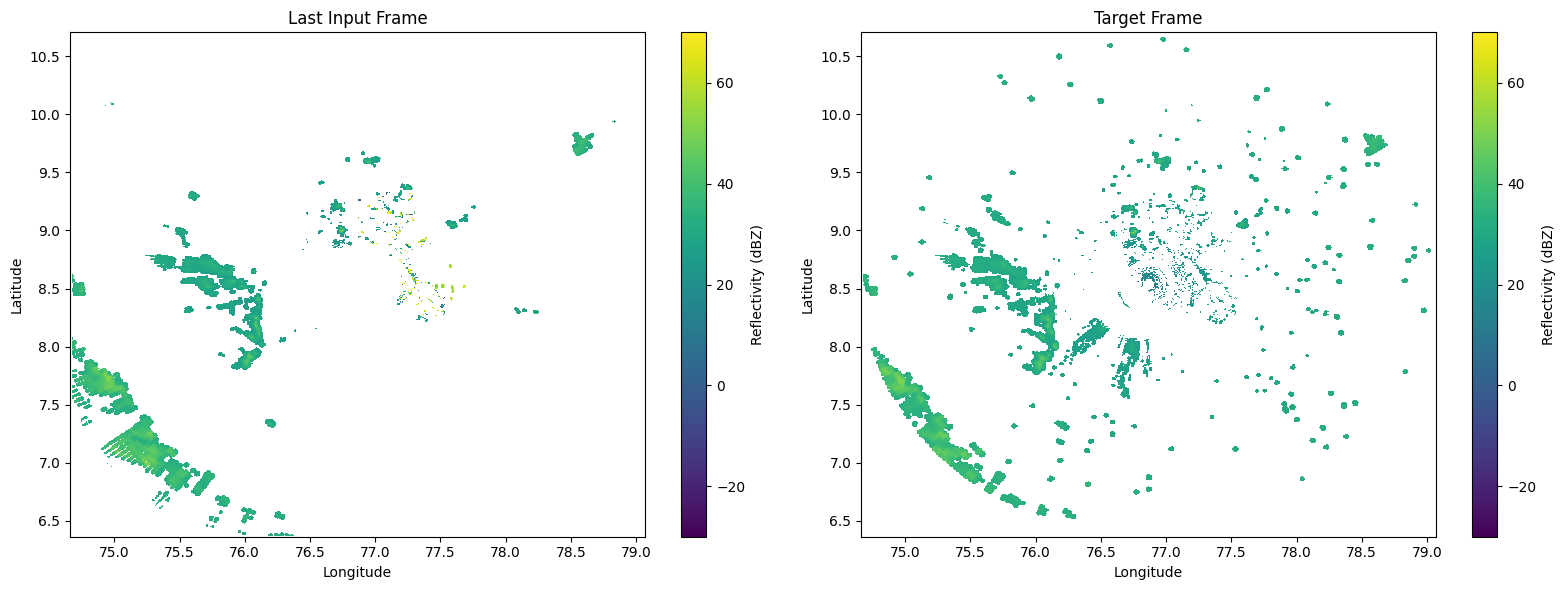

In [3]:
plot_sample(dataset[5])

(1, 481, 481) (481, 481) (481, 481)


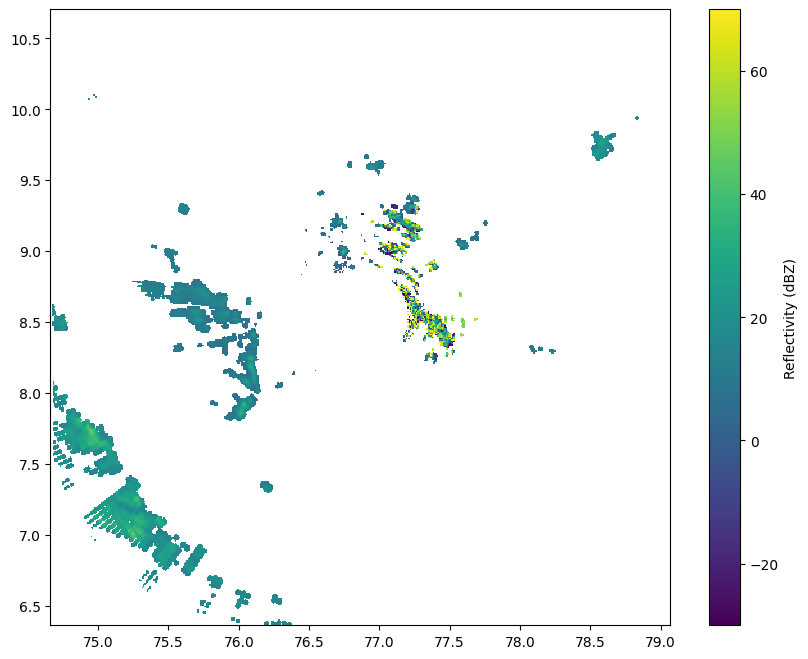

In [4]:
ds = xr.open_dataset(dataset.files[5])
plt.figure(figsize=(10, 8))
data = ds['DBZ'].clip(min=-30, max=70)
print(ds['DBZ'].shape, ds['lon'].shape, ds['lat'].shape)
plt.pcolormesh(ds['lon'], ds["lat"], data[0], cmap='viridis', shading='auto')
plt.colorbar(label="Reflectivity (dBZ)")
plt.show()

In [5]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers = 2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers = 2, pin_memory=True)
print(f"Train size: {len(train_loader.dataset)}, Test size: {len(test_loader.dataset)}")
for out in train_loader:
    print(f"Input shape: {out["input"].shape}, Target shape: {out["target"].shape}")
    break

Train size: 18756, Test size: 4689


Input shape: torch.Size([8, 1, 512, 512]), Target shape: torch.Size([8, 1, 512, 512])


In [10]:
def plot_all_frames(sample, vmin=0, vmax=70, label1="Input Frame", label2="Target Frame", save = False, name = None):
    x = sample['input'].numpy()  # shape: [COND_W, H, W]
    y = sample['target'].numpy() # shape: [PRED_W, H, W]
    lat = sample['lat'].numpy()
    lon = sample['lon'].numpy()
    H, W = lat.shape
    pad_h = x.shape[1] - H
    pad_w = x.shape[2] - W
    top = pad_h // 2
    left = pad_w // 2

    n_x = x.shape[0]
    n_y = y.shape[0]

    plt.figure(figsize=(4 * max(n_x, n_y), 4 * 2))

    # Plot all input frames
    for i in range(n_x):
        x_cropped = x[i, top:top+H, left:left+W]
        x_cropped = (x_cropped + 1.0) / 2.0 * 100 - 30
        plt.subplot(2, max(n_x, n_y), i + 1)
        plt.pcolormesh(lon, lat, x_cropped, cmap='Blues', vmin=vmin, vmax=vmax)
        plt.title(f"{label1} {i+1}")
        plt.axis('off')

    # Plot all target frames
    for i in range(n_y):
        y_cropped = y[i, top:top+H, left:left+W]
        y_cropped = (y_cropped + 1.0) / 2.0 * 100 - 30
        plt.subplot(2, max(n_x, n_y), max(n_x, n_y) + i + 1)
        plt.pcolormesh(lon, lat, y_cropped, cmap='Blues', vmin=vmin, vmax=vmax)
        plt.title(f"{label2} {i+1}")
        plt.axis('off')

    plt.tight_layout()
    if save:
        plt.savefig(f"plots/{name}.png", dpi=300)
    plt.show()


In [1]:
!nvidia-smi

/bin/bash: /home/vatsal/miniconda3/envs/jaxcuda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Thu May 22 11:38:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:65:00.0 Off |                  Off |
| 31%   37C    P3             75W /  450W |      31MiB /  24564MiB |      0%      Default |
|               